# 🧠 Agrupamiento de Pokémon con K-Means
Análisis de las estadísticas de batalla de Pokémon para descubrir perfiles de combate mediante técnicas de Machine Learning.


## 📚 Introducción

El objetivo de este proyecto es agrupar Pokémon según sus estadísticas de batalla (HP, Attack, Defense, Sp. Atk, Sp. Def, Speed) utilizando el algoritmo de clustering K-Means. Este análisis permitirá descubrir perfiles de Pokémon con características similares que podrían ser útiles para estrategias de juego, merchandising, o balanceo de equipos.

---


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA



| Librería                       | ¿Para qué la usamos?                            |
| ------------------------------ | ----------------------------------------------- |
| `sys`, `pathlib.Path`          | Modificar el sistema de rutas de Python.        |
| `pandas`                       | Cargar y manipular datos tipo tabla.            |
| `numpy`                        | Cálculo numérico eficiente.                     |
| `matplotlib.pyplot`            | Gráficos básicos (codo, scatter, etc).          |
| `seaborn`                      | Gráficos mejorados con colores y temas.         |
| `StandardScaler` (`sklearn`)   | Escalar datos (media 0, varianza 1).            |
| `PCA` (`sklearn`)              | Reducción de dimensiones (visualizar clusters). |
| `KMeans` (`sklearn`)           | Algoritmo de clustering K-Means.                |
| `silhouette_score` (`sklearn`) | Validar calidad de los clusters.                |


## 📥 Cargar Datos

Cargamos el dataset de Pokémon.

In [2]:
df = pd.read_csv("../data/raw/Pokemon.csv")
df.head()


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


## 🎯 Selección de Características

Seleccionamos las estadísticas numéricas de interés para el análisis de clustering.


In [3]:
# One-Hot Encoding de Type 1 y Type 2
df_types = df[['Type 1', 'Type 2']].fillna('None')
encoder = OneHotEncoder()
types_encoded = encoder.fit_transform(df_types)

# Seleccionar estadísticas numéricas
num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
df_stats = df[num_cols]

# Estandarizar estadísticas
scaler = StandardScaler()
stats_scaled = scaler.fit_transform(df_stats)

# Concatenar tipos codificados + estadísticas escaladas
from scipy.sparse import hstack
X = hstack([types_encoded, stats_scaled])


## ⚙️ Normalización de Datos

Aplicamos StandardScaler para estandarizar los datos (media=0, varianza=1).


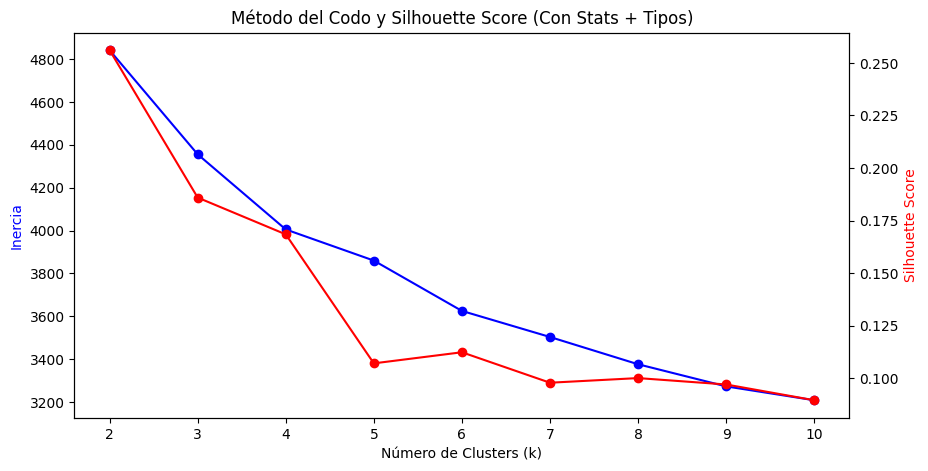

In [4]:
inertia = []
silhouette = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, labels))

# Graficar
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(k_range, inertia, 'bo-', label='Inercia')
ax2.plot(k_range, silhouette, 'ro-', label='Silhouette Score')

ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inercia', color='b')
ax2.set_ylabel('Silhouette Score', color='r')
ax1.set_xticks(k_range)
plt.title('Método del Codo y Silhouette Score (Con Stats + Tipos)')
plt.show()


In [5]:
k_opt = 5  # o el valor que elijas
kmeans = KMeans(n_clusters=k_opt, random_state=42)
df['cluster'] = kmeans.fit_predict(X)



## 🏷️ Aplicación Final de K-Means y Análisis de Clusters

Aplicamos el algoritmo de K-Means usando el número óptimo de clusters identificado previamente (`k=4`).

### 📌 Asignación de Clusters
Cada Pokémon es asignado a uno de los 4 clusters basándose en sus estadísticas normalizadas.

### 📊 Distribución de Pokémon por Cluster
Contamos cuántos Pokémon pertenecen a cada cluster para analizar el tamaño y balance de los grupos.

### 🧩 Interpretación de los Clusters
Calculamos los centroides (valores promedio) de cada cluster, revirtiendo la normalización para interpretar los resultados en escala original (HP, Attack, Defense, etc.).

Este análisis permite entender los perfiles promedio de cada grupo de Pokémon.


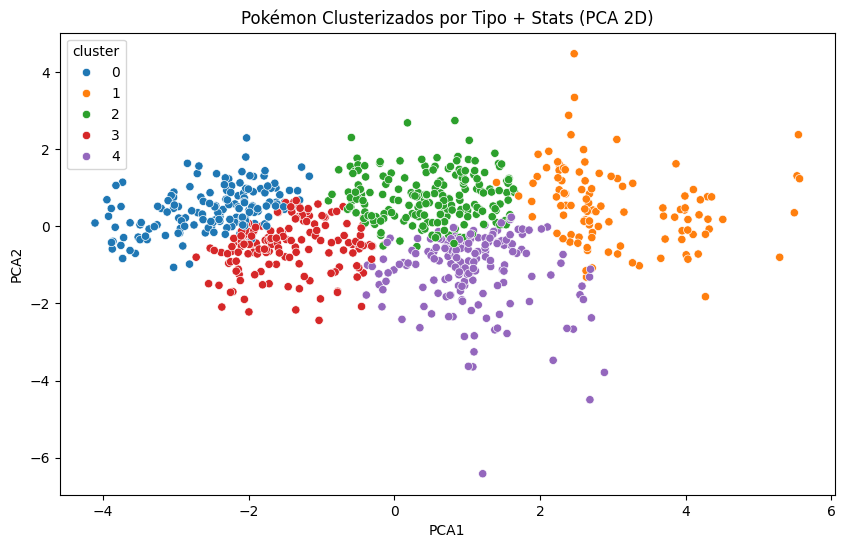

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster', palette='tab10')
plt.title('Pokémon Clusterizados por Tipo + Stats (PCA 2D)')
plt.show()



In [7]:
# Agrupamos por 'cluster' y calculamos el promedio de las estadísticas
cluster_stats = df.groupby('cluster')[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].mean().round(1)

# Mostrar la tabla
display(cluster_stats)


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
cluster,,,,,,,
0,280.2,45.1,46.6,41.7,46.3,44.9,55.7
1,625.5,89.9,120.9,93.8,120.5,98.4,102.0
2,466.6,72.5,84.8,66.0,79.3,72.4,91.6
3,344.7,58.6,65.9,68.3,52.4,56.9,42.5
4,500.2,84.0,86.9,104.3,77.7,92.6,54.8
